In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('Sentiment_Mental_health_dataset.csv')

In [3]:
df.head()

,statement,status
0,Anyone else have symptoms much improved after ...,Bipolar
1,"I basicaly do not exist, sure feels that way. ...",Suicidal
2,Finding a sense of self It's like one minute I...,Personality_disorder
3,Putting into words what were just tangles in m...,Anxiety
4,Anxiety makes me worry about my public image s...,Anxiety


In [4]:
df.shape

(26350, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26350 entries, 0 to 26349
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  26350 non-null  object
 1   status     26350 non-null  object
dtypes: object(2)
memory usage: 411.8+ KB


In [6]:
# checking null values
df.isnull().sum()

statement    0
status       0
dtype: int64

In [7]:
# checking null values
df.duplicated().sum()

np.int64(17)

In [8]:
print(df[df.duplicated()])

                                               statement                status
2124   I’m not one to post like this but I don’t know...              Suicidal
2644                                         That is all              Suicidal
7158   it’s been such a long journey with trial and e...  Personality_disorder
10465  As it is highly connected that traumas (especc...  Personality_disorder
11541                                                  .              Suicidal
13878                                                  .              Suicidal
14938  I found out recently that the man I’ve been da...  Personality_disorder
17099  Researchers at Federation University are seeki...  Personality_disorder
19676  Hi guys, I’m looking for responses for my surv...                Stress
20847                                             Please              Suicidal
21336  Can I use heat pad to warm up the muscles befo...                Normal
21569                                        That is

In [9]:
# dropping the duplicates 

df.drop_duplicates(inplace=True) 

In [10]:
df['status'].value_counts()

status
Suicidal                5592
Anxiety                 4704
Normal                  4574
Depression              4111
Personality_disorder    2810
Bipolar                 2720
Stress                  1822
Name: count, dtype: int64

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

# keep important negation words
negation_words = {"not", "no", "nor", "never"}
stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase
    text = text.lower()                          # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)   # remove urls
    text = re.sub(r'\S+@\S+', '', text)          # remove emails
    text = re.sub(r'[^a-z\s]', '', text)         # remove numbers & special chars
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces

    # tokenize
    tokens = word_tokenize(text)

    # remove stopwords & lemmatize
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]

    return " ".join(tokens)

In [12]:
df['processed_text'] = df['statement'].apply(preprocess_text)

df[['statement', 'processed_text']].head()

,statement,processed_text
0,Anyone else have symptoms much improved after ...,anyone else symptom much improved leaving spou...
1,"I basicaly do not exist, sure feels that way. ...",basicaly not exist sure feel way no friend no ...
2,Finding a sense of self It's like one minute I...,finding sense self like one minute im one pers...
3,Putting into words what were just tangles in m...,putting word tangle brain chronic anxiety toda...
4,Anxiety makes me worry about my public image s...,anxiety make worry public image damn much im f...


In [13]:
## Encoding status 

mapping = {
    'Anxiety': 0,
    'Bipolar': 1,
    'Depression': 2,
    'Normal': 3,
    'Personality_disorder': 4,
    'Stress': 5,
    'Suicidal': 6
}

df['status_encoded'] = df['status'].map(mapping)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26333 entries, 0 to 26349
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   statement       26333 non-null  object
 1   status          26333 non-null  object
 2   processed_text  26333 non-null  object
 3   status_encoded  26333 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [15]:
X = df["processed_text"]
y = df["status_encoded"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [17]:
# Train an interpretable baseline text classifier (TF-IDF + linear model)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [35]:
pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.8,
                max_features=10000,
                sublinear_tf=True,
            ),
        ),
        (
            "logreg",
            LogisticRegression(
                max_iter=1000,
                class_weight='balanced'
            ),
        ),
    ]
)

In [36]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [37]:
print("Baseline model fit complete.")
print(pipeline)

Baseline model fit complete.
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=10000, min_df=2,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])


# Evaluation

Validation classification report (TF-IDF + LogisticRegression):
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       941
           1       0.76      0.74      0.75       544
           2       0.58      0.58      0.58       822
           3       0.97      0.97      0.97       915
           4       0.77      0.74      0.75       562
           5       0.73      0.76      0.75       364
           6       0.71      0.76      0.73      1119

    accuracy                           0.77      5267
   macro avg       0.76      0.76      0.76      5267
weighted avg       0.77      0.77      0.77      5267



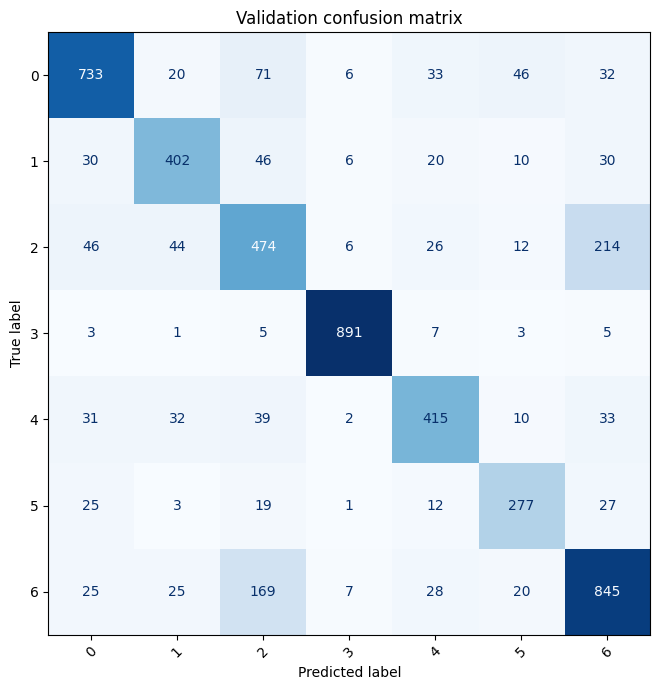

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on validation
y_pred = pipeline.predict(X_test)

print("Validation classification report (TF-IDF + LogisticRegression):")
print(classification_report(y_test, y_pred))

# Confusion matrix
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(9, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45, colorbar=False)
ax.set_title("Validation confusion matrix")
plt.tight_layout()
plt.show()

# Save the model

In [39]:
import joblib

In [40]:
joblib.dump(pipeline, "mental_health_model.pkl")

['mental_health_model.pkl']

# Predict new data 

In [41]:
# Load pipeline
pipeline = joblib.load("mental_health_model.pkl")

# Example new text (raw, not preprocessed)
new_text = "I feel very anxious and can't sleep."

# Preprocess (same as training)
clean_text = preprocess_text(new_text)

# Predict 
pred_encoded = pipeline.predict([clean_text])[0]

# Decode back to category
reverse_mapping = {0:'Anxiety', 1:'Bipolar', 2:'Depression', 3:'Normal',
                   4:'Personality_disorder', 5:'Stress', 6:'Suicidal'}

print("Predicted category:", reverse_mapping[pred_encoded])


Predicted category: Anxiety
